# Image Classification
In this project, we'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. We'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  We'll build a convolutional neural network consisting of convolutional, max pooling, dropout, and fully connected layers.  At the end, we'll get to see neural network's predictions on the sample images we are running through the trained network.
Parts of the codebase is provided by Udacity.
## Get the Data
First we're going to download the dataset from [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

CIFAR-10 Dataset: 171MB [02:18, 1.23MB/s]                              


All files found!


## Let us explore the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck



Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


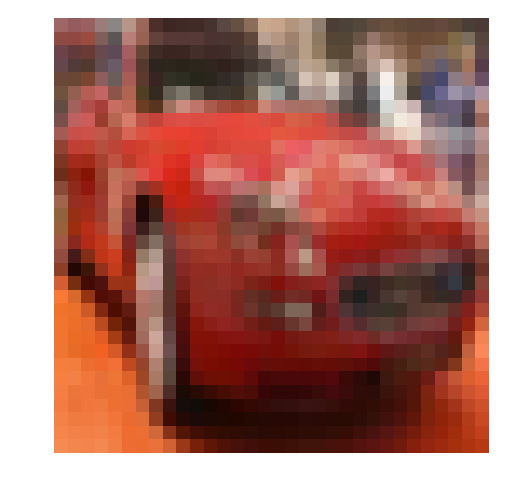

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1.

In [3]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    return x/255.0

tests.test_normalize(normalize)

Tests Passed


### One-hot encode
Here we'll implement the `one_hot_encode` function. The input, `x`, are a list of labels.  Implement the function to return the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`. 

In [4]:
import numpy as np
from sklearn import preprocessing

def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """

    one_hot = np.zeros(shape=(len(x), 10))
    for i in range(0, len(one_hot)):
        one_hot[i][x[i]] = 1
    return one_hot

tests.test_one_hot_encode(one_hot_encode)

Tests Passed


## Preprocessing the data and saveing it
The code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [5]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
This is the first checkpoint. The preprocessed data has been saved to disk.

In [6]:
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
For the neural network, we'll build each layer into a function.  

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. 

In [7]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a bach of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    
    return tf.placeholder(tf.float32, shape = (None, *image_shape), name = "x")


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """

    return tf.placeholder(tf.float32, shape= (None, n_classes), name = "y")


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32, name = "keep_prob")

tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, we'll implement the function `conv2d_maxpool` to apply convolution then max pooling:

In [8]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # Create the weight and bias
    # height, width, input_depth, output_depth
    weights = tf.Variable(tf.random_normal([*conv_ksize, int(x_tensor.shape[3]), conv_num_outputs], mean=0.0, stddev=0.1))
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    
    # Apply a convolution
    conv_layer = tf.nn.conv2d(x_tensor, weights, [1,*conv_strides, 1], padding = 'SAME')
    # Add bias
    conv_layer = tf.nn.bias_add(conv_layer, bias)
    # Apply activation function
    conv_layer = tf.nn.relu(conv_layer)
    
    # Apply Max Pooling
    conv_layer = tf.nn.max_pool(conv_layer, [1, *pool_ksize, 1], [1, *pool_strides, 1], padding = 'SAME')
    
    return conv_layer 


tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer
Implementing the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.

In [9]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    shape = x_tensor.get_shape().as_list()
    length = shape[1]*shape[2]*shape[3]
    return tf.reshape(x_tensor, [-1, length])

tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer
Implementing the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*).

In [11]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    
    num_input = x_tensor.get_shape().as_list()[1]
    weight = tf.Variable(tf.truncated_normal([num_input, num_outputs], mean=0.0, stddev=0.1))
    bias = tf.Variable(tf.zeros(num_outputs))
    out = tf.add(tf.matmul(x_tensor, weight), bias)
    return tf.nn.relu(out)


tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer
Implementing the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*).

In [12]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    num_input = x_tensor.get_shape().as_list()[1]
    weights = tf.Variable(tf.truncated_normal([num_input, num_outputs], mean=0, stddev=0.1))
    bias = tf.Variable(tf.zeros(num_outputs))
    return tf.add(tf.matmul(x_tensor, weights), bias)


tests.test_output(output)

Tests Passed


### Create Convolutional Model
Implementing the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.


In [13]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    
    conv1_num_outputs = 64
    conv1_ksize = (3, 3)
    conv1_strides = (1, 1)
    
    conv2_num_outputs = 64
    conv2_ksize = (3, 3)
    conv2_strides = (1, 1)
    
    conv3_num_outputs = 64
    conv3_ksize = (3, 3)
    conv3_strides = (1, 1)
    
    pool1_ksize = (2, 2)
    pool1_strides = (2, 2)
    pool2_ksize = (2, 2)
    pool2_strides = (2, 2)
    pool3_ksize = (2, 2)
    pool3_strides = (2, 2)
    
    num_outputs_fc1 = 128
    num_outputs_fc2 = 64
    num_outputs_fc3 = 10
    
    num_outputs = 10
    
    # Function Definition from Above:
    # conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    conv1 = conv2d_maxpool(x, conv1_num_outputs, conv1_ksize, conv1_strides, pool1_ksize, pool1_strides)
    conv2 = conv2d_maxpool(conv1, conv2_num_outputs, conv2_ksize, conv2_strides, pool2_ksize, pool2_strides)
    conv3 = conv2d_maxpool(conv2, conv3_num_outputs, conv3_ksize, conv3_strides, pool3_ksize, pool3_strides)

    # Function Definition from Above:
    #   flatten(x_tensor)
    
    flat = flatten(conv3)
    
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    
    fc1 = fully_conn(flat, num_outputs_fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    fc2 = fully_conn(fc1, num_outputs_fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    fc3 = fully_conn(fc2, num_outputs_fc3)
    fc3 = tf.nn.dropout(fc3, keep_prob)
    
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    
    logits = output(fc2, num_outputs)
    
    # return logits as output
    return logits


##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Training the Neural Network
### Single Optimization
Implementing the function `train_neural_network` to do a single optimization.  The optimization uses `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

In [14]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: keep_probability})
    pass


tests.test_train_nn(train_neural_network)

Tests Passed


### Show Stats
Implementing the function `print_stats` to print loss and validation accuracy.  Using the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  

In [15]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    loss = session.run(cost, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: 1.})
                     
    valid_acc = session.run(accuracy, feed_dict={
                x: valid_features,
                y: valid_labels,
                keep_prob: 1.})
    
    print('Loss: {:>10.4f} Validation Accuracy: {:.4f}%'.format(
                loss,
                valid_acc*100))
    '''
    print('Loss: {}'.format(
                loss))
    '''           
    pass

### Hyperparameters
Tuning the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` Common sizes of batches are:
 * 64
 * 128
 * 256
* Set `keep_probability` to the probability of keeping a node using dropout

In [28]:
# Tune Parameters
epochs = 30
batch_size = 64
keep_probability = 0.6

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, we are using a single batch. This should save time while iterating on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, we'll run the model on all the data in the next section.

In [29]:

print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.0419 Validation Accuracy: 27.8800%
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.8510 Validation Accuracy: 39.8000%
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.7483 Validation Accuracy: 42.5800%
Epoch  4, CIFAR-10 Batch 1:  Loss:     1.6175 Validation Accuracy: 44.2400%
Epoch  5, CIFAR-10 Batch 1:  Loss:     1.5419 Validation Accuracy: 47.2000%
Epoch  6, CIFAR-10 Batch 1:  Loss:     1.2740 Validation Accuracy: 51.4200%
Epoch  7, CIFAR-10 Batch 1:  Loss:     1.0967 Validation Accuracy: 51.3600%
Epoch  8, CIFAR-10 Batch 1:  Loss:     1.0423 Validation Accuracy: 54.4200%
Epoch  9, CIFAR-10 Batch 1:  Loss:     0.9141 Validation Accuracy: 55.9600%
Epoch 10, CIFAR-10 Batch 1:  Loss:     0.9238 Validation Accuracy: 55.8600%
Epoch 11, CIFAR-10 Batch 1:  Loss:     0.8442 Validation Accuracy: 58.2000%
Epoch 12, CIFAR-10 Batch 1:  Loss:     0.7309 Validation Accuracy: 58.4000%
Epoch 13, CIFAR-10 Batch 1:  Loss:     0.7162

### Fully Train the Model
Now that we have got a fairly good accuracy with a single CIFAR-10 batch, we'll try it with all five batches.

In [30]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.1301 Validation Accuracy: 28.2800%
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.7348 Validation Accuracy: 37.7600%
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.4745 Validation Accuracy: 39.5000%
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.5280 Validation Accuracy: 44.8600%
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.4882 Validation Accuracy: 46.9000%
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.5042 Validation Accuracy: 50.5800%
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.2878 Validation Accuracy: 51.3200%
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.1004 Validation Accuracy: 51.4600%
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.2393 Validation Accuracy: 55.4600%
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.2488 Validation Accuracy: 55.2600%
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.1936 Validation Accuracy: 58.6200%
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.1138 Validation Accuracy: 56.7000%
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.9653 Validation Accuracy: 59.3200%


# Checkpoint
The model has been saved to disk.
## Test Model
Testing our model against the test dataset.  This will be our final accuracy.

Testing Accuracy: 0.7339769108280255



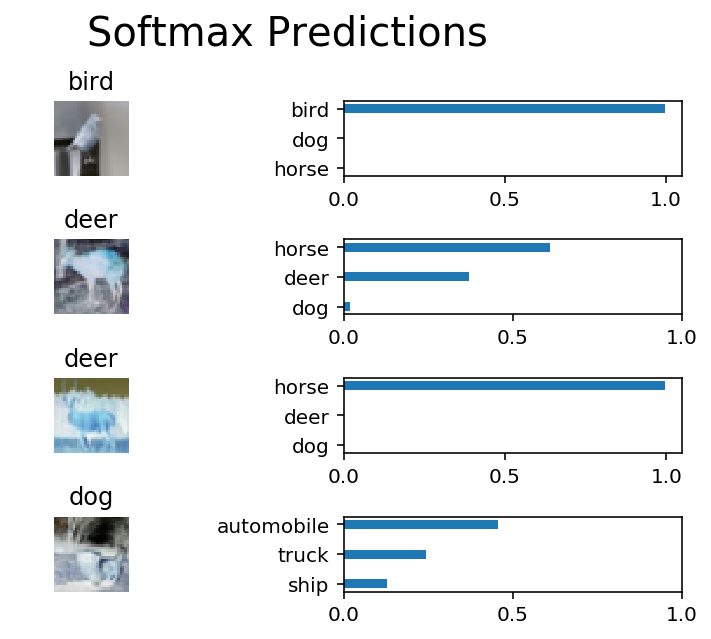

In [31]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Why 70-75% Accuracy?
First things first, 70% isn't bad for a simple CNN like this one.  Pure guessing would get you 10% accuracy. The reason why the accuracy is not higher is, that some more advanced techniques havn't been used in this simple model yet.